# **Importing Packages**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import os
from tqdm import tqdm
from torchvision import models
import cv2




# **Creating Training Dataset**

This class is created to load and apply masks to the images

****

In [4]:
class InpaintingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = os.listdir(root_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        try:
            image = cv2.imread(img_name)
            if image is None:
                raise Exception(f"Unable to load image: {img_name}")
            masked_image, original_image = self.__create_mask(image)
            if self.transform:
                masked_image = self.transform(masked_image)
                original_image = self.transform(original_image)
            return masked_image, original_image
        except Exception as e:
            print(f"Error processing image {img_name}: {e}")
            return None, None

    def __create_mask(self, img):
      mask = np.full_like(img, 255)
      for _ in range(np.random.randint(1, 4)):
          x1, y1 = np.random.randint(1, img.shape[0]), np.random.randint(1, img.shape[1])
          x2, y2 = np.random.randint(x1, img.shape[0]), np.random.randint(y1, img.shape[1])
          cv2.rectangle(mask, (x1, y1), (x2, y2), (0, 0, 0), -1)  
      masked_image = cv2.bitwise_and(img, mask)
      return masked_image, img 










# **Loading and displaying the training data**

Chosen training dataset is called "Google-Street-View'. It is split to testing and training in a 0.9/0.1 split

Link to dataset : https://www.kaggle.com/datasets/paulchambaz/google-street-view

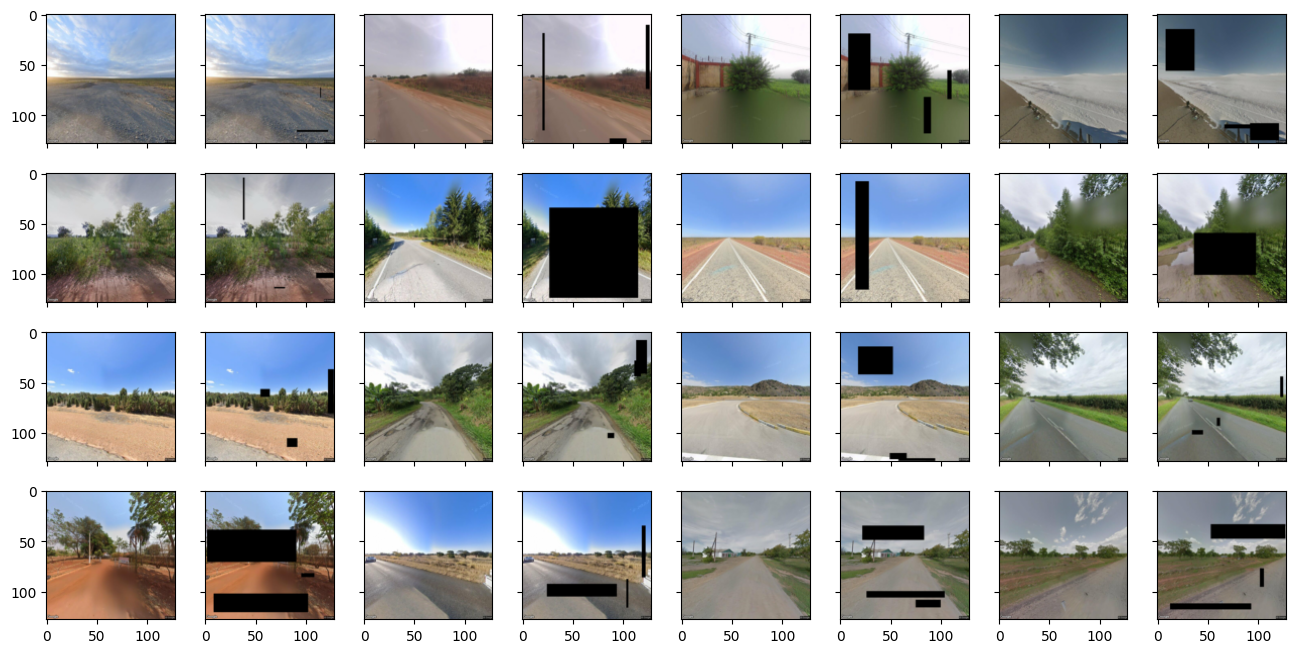

In [5]:
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, random_split
import numpy as np

if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    dataset_path = "google-street-view"  
    dataset_augmented = InpaintingDataset(root_dir=dataset_path, transform=transform)
    train_dataset_augmented, test = random_split(dataset_augmented, [0.9, 0.1]) 
    train_loader = DataLoader(train_dataset_augmented, batch_size=32, shuffle=True)

    sample_masks, sample_labels = next(iter(train_loader))
    sample_images = [None] * (len(sample_masks) + len(sample_labels))
    sample_images[::2] = sample_labels
    sample_images[1::2] = sample_masks
    
    fig = plt.figure(figsize=(16., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.3)

    for ax, image in zip(grid, sample_images):
        image_rgb = image[[2, 1, 0], :, :]  
        ax.imshow(image_rgb.permute(1, 2, 0))

    plt.show()


# **Defining the GAN Architechture**

The Generator used is a Convulation Autoencoding Network based on U-Net

The Discriminator used is based on ResNet

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.generator_model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),            
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),             
            nn.Conv2d(512, 4000, 1),
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ReLU(),            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(),             
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.generator_model(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 3, 1, 1)
        )

    def forward(self, x):
        x = self.conv(x)
        return x



# **Training the GAN**

Initial Weights are defined (I did not experiment to try different Initial Weights, I applied weights given on a paper by Deepak Pathak of CMU)


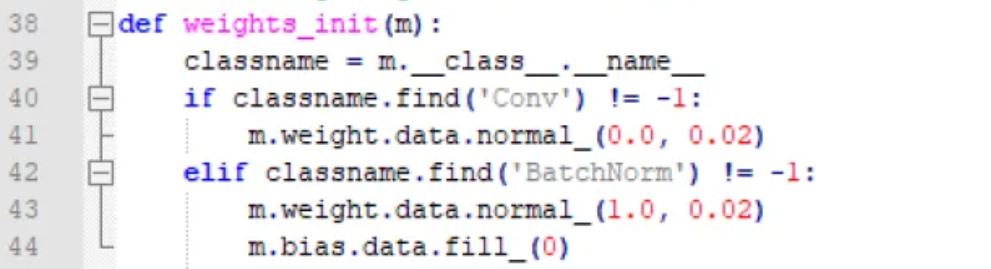

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)
print (device)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
generator.apply(weights_init)
discriminator.apply(weights_init)

cuda


Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

Training Loop

Adam Optimizer used for both networks Did not experiment with other optimizers. Experimented with various learning rates. 0.0002 worked best

Generator trained on an equal weightage of BCELoss and L1 Loss. Experimented on various weights and loss functions. This worked best

Discriminator trained on BCELoss only. Equal weightage to both real and fake loss

In [6]:


optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterionMSE = torch.nn.BCELoss() #Forgot to change variable name...fix later
criterion = torch.nn.L1Loss()
criterionMSE.to(device)
criterion.to(device)


def train_GAN(generator, discriminator, criterionMSE,criterion, optimizer_G, optimizer_D, dataloader, num_epochs=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    generator.train()
    discriminator.train()

    for epoch in range(num_epochs):
        discriminator_losses = []
        generator_losses = []

        for i, (masked_images, original_images) in enumerate(dataloader):
            masked_images = masked_images.to(device)
            original_images = original_images.to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            fake_images = generator(masked_images)
            fake_outputs = discriminator(fake_images.detach())
            real_outputs = discriminator(original_images)
            d_loss_fake = criterionMSE(fake_outputs, torch.zeros_like(fake_outputs))
            d_loss_real = criterionMSE(real_outputs, torch.ones_like(real_outputs))
            d_loss = 0.5 * (d_loss_fake + d_loss_real)
            d_loss.backward()
            optimizer_D.step()
            discriminator_losses.append(d_loss.item())


           
            optimizer_G.zero_grad()
            fake_outputs = discriminator(fake_images)
            adv_loss = criterionMSE(fake_outputs, torch.ones_like(fake_outputs))

            L1_loss = criterion((fake_images),(original_images))
            g_loss = 0.5*adv_loss + 0.5*L1_loss 
            g_loss.backward()
            optimizer_G.step()
            generator_losses.append(g_loss.item())
            
           


            if i % 1000 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(dataloader)}], "
                    f"Discriminator Loss: {d_loss.item():.4f}, Generator Loss: {g_loss.item():.4f}"
                )




     


Training

In [7]:


train_GAN(generator, discriminator,criterionMSE, criterion, optimizer_G, optimizer_D, train_loader, num_epochs=100)


  0%|          | 0/282 [00:00<?, ?it/s]

Epoch [1/100], Batch [1/282], Discriminator Loss: 1.0207, Generator Loss: 2.9232


  0%|          | 0/282 [05:37<?, ?it/s]


Epoch [2/100], Batch [1/282], Discriminator Loss: 0.2800, Generator Loss: 0.2208


  0%|          | 0/282 [05:44<?, ?it/s]


Epoch [3/100], Batch [1/282], Discriminator Loss: 0.2638, Generator Loss: 0.1933


  0%|          | 0/282 [06:22<?, ?it/s]


Epoch [4/100], Batch [1/282], Discriminator Loss: 0.2691, Generator Loss: 0.1737


  0%|          | 0/282 [06:34<?, ?it/s]


Epoch [5/100], Batch [1/282], Discriminator Loss: 0.2982, Generator Loss: 0.1708


  0%|          | 0/282 [07:26<?, ?it/s]


Epoch [6/100], Batch [1/282], Discriminator Loss: 0.2579, Generator Loss: 0.1663


  0%|          | 0/282 [08:33<?, ?it/s]


Epoch [7/100], Batch [1/282], Discriminator Loss: 0.2547, Generator Loss: 0.1659


  0%|          | 0/282 [08:21<?, ?it/s]


Epoch [8/100], Batch [1/282], Discriminator Loss: 0.2711, Generator Loss: 0.1650


  0%|          | 0/282 [06:05<?, ?it/s]


Epoch [9/100], Batch [1/282], Discriminator Loss: 0.2572, Generator Loss: 0.1558


  0%|          | 0/282 [06:06<?, ?it/s]


Epoch [10/100], Batch [1/282], Discriminator Loss: 0.2565, Generator Loss: 0.1652


  0%|          | 0/282 [06:32<?, ?it/s]


Epoch [11/100], Batch [1/282], Discriminator Loss: 0.2529, Generator Loss: 0.1485


  0%|          | 0/282 [05:27<?, ?it/s]


Epoch [12/100], Batch [1/282], Discriminator Loss: 0.2502, Generator Loss: 0.1573


  0%|          | 0/282 [05:23<?, ?it/s]


Epoch [13/100], Batch [1/282], Discriminator Loss: 0.2563, Generator Loss: 0.1521


  0%|          | 0/282 [05:29<?, ?it/s]


Epoch [14/100], Batch [1/282], Discriminator Loss: 0.2508, Generator Loss: 0.1490


  0%|          | 0/282 [06:40<?, ?it/s]


Epoch [15/100], Batch [1/282], Discriminator Loss: 0.2496, Generator Loss: 0.1577


  0%|          | 0/282 [07:55<?, ?it/s]


Epoch [16/100], Batch [1/282], Discriminator Loss: 0.2521, Generator Loss: 0.1537


Progress Bar Glitched for some reason. Not really relevant. Fixing later if time 

# **Defining the function for displaying test images**

Using OpenCV for this. Converting BGR to RGB First.

For better results I overlay the masked image on top of the generated image.


In [8]:
def display_images(original_images, masked_images, generated_images):
    fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))
    
    for i in range(10):
        original_np = original_images[i].permute(1, 2, 0).cpu().numpy()
        masked_np = masked_images[i].permute(1, 2, 0).cpu().numpy()
        generated_np = generated_images[i].detach().permute(1, 2, 0).cpu().numpy()
        
        original_rgb = cv2.cvtColor(original_np, cv2.COLOR_BGR2RGB)
        masked_rgb = cv2.cvtColor(masked_np, cv2.COLOR_BGR2RGB)
        generated_rgb = cv2.cvtColor(generated_np, cv2.COLOR_BGR2RGB)
      
        
        inpainted_pixels = np.where(masked_np == 0)
        if inpainted_pixels[0].size == 0:  
            inpainted_region = masked_rgb.copy()
        else:
            min_row = max(0, min(inpainted_pixels[0]) - 5)
            max_row = min(masked_np.shape[0], max(inpainted_pixels[0]) + 5)
            min_col = max(0, min(inpainted_pixels[1]) - 5)
            max_col = min(masked_np.shape[1], max(inpainted_pixels[1]) + 5)
        
            inpainted_region = masked_rgb.copy()
            inpainted_region[min_row:max_row, min_col:max_col] = generated_rgb[min_row:max_row, min_col:max_col]
        
        axes[0, i].imshow(original_rgb)
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        axes[1, i].imshow(masked_rgb)
        axes[1, i].set_title('Masked')
        axes[1, i].axis('off')

        axes[2, i].imshow(inpainted_region)
        axes[2, i].set_title('Generated with Mask')
        axes[2, i].axis('off')

    plt.tight_layout()
    plt.show()
import random

def DisplayTest(augmented_set):
    random_indices = random.sample(range(len(augmented_set)), 10)
    sample_images = [augmented_set[i] for i in random_indices]

    masked_images, original_images = zip(*sample_images)

    masked_images = torch.stack(masked_images)
    original_images = torch.stack(original_images)

    device = torch.device("cpu")
    generator.to(device)
    masked_images = masked_images.to(device)
    original_images = original_images.to(device)

    generated_images = generator(masked_images)

    display_images(original_images, masked_images, generated_images)












# **Displaying the images passed through the model**

First the training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


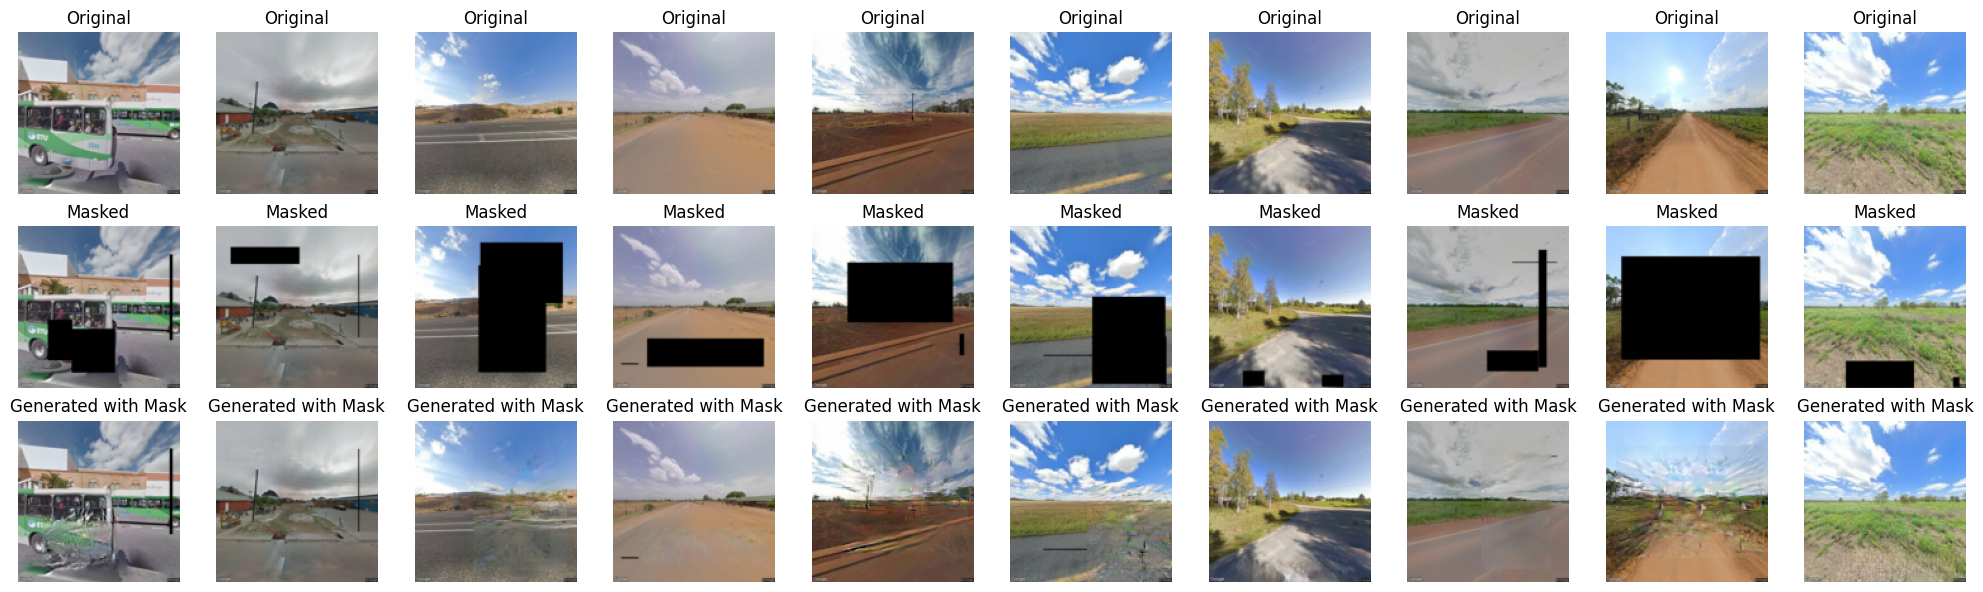

In [11]:
DisplayTest(train_dataset_augmented)

Now Testing

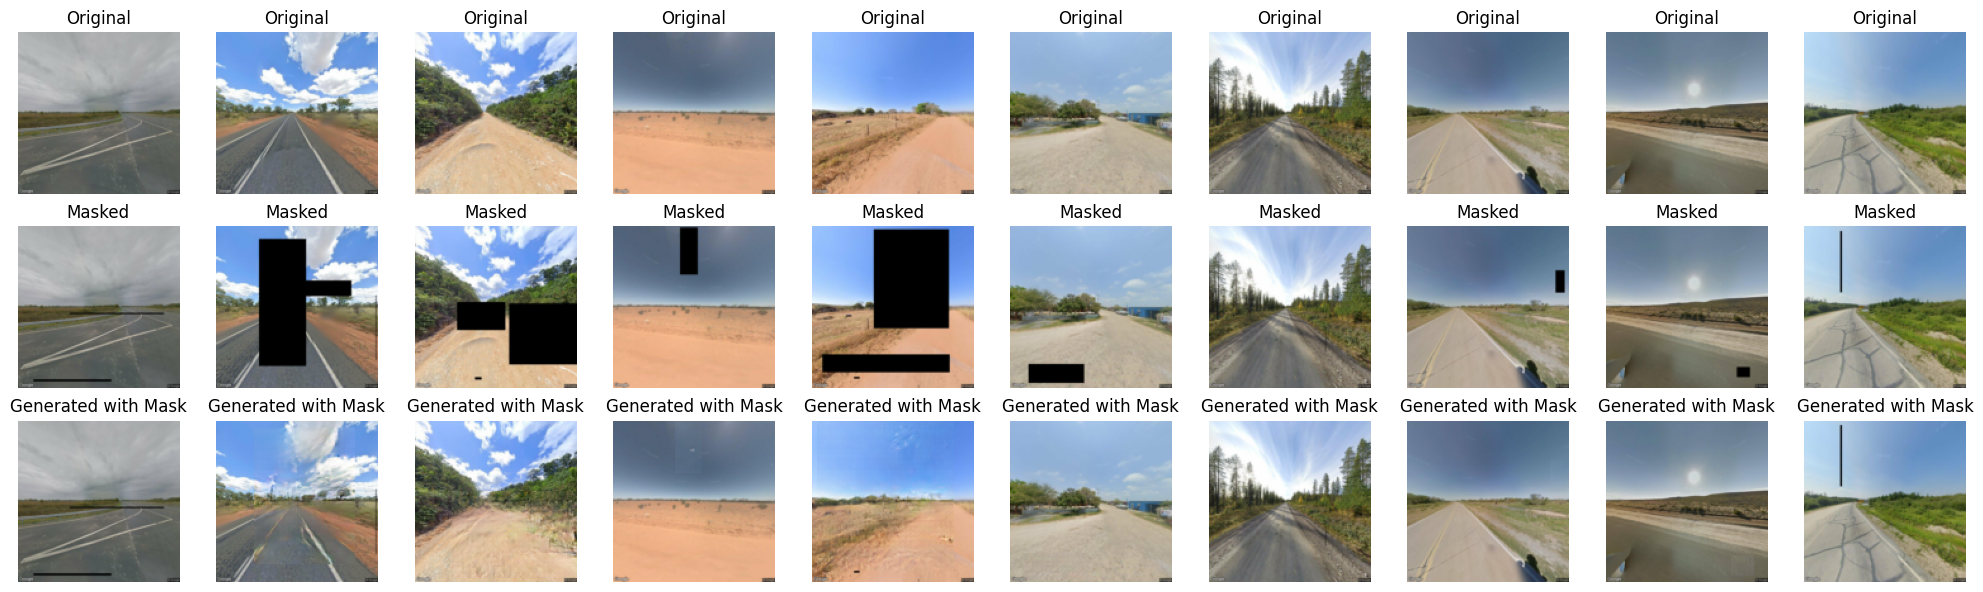

In [12]:
DisplayTest(test)

# **Testing the model on an Unseen Dataset**

Using Paris-Street-View to test

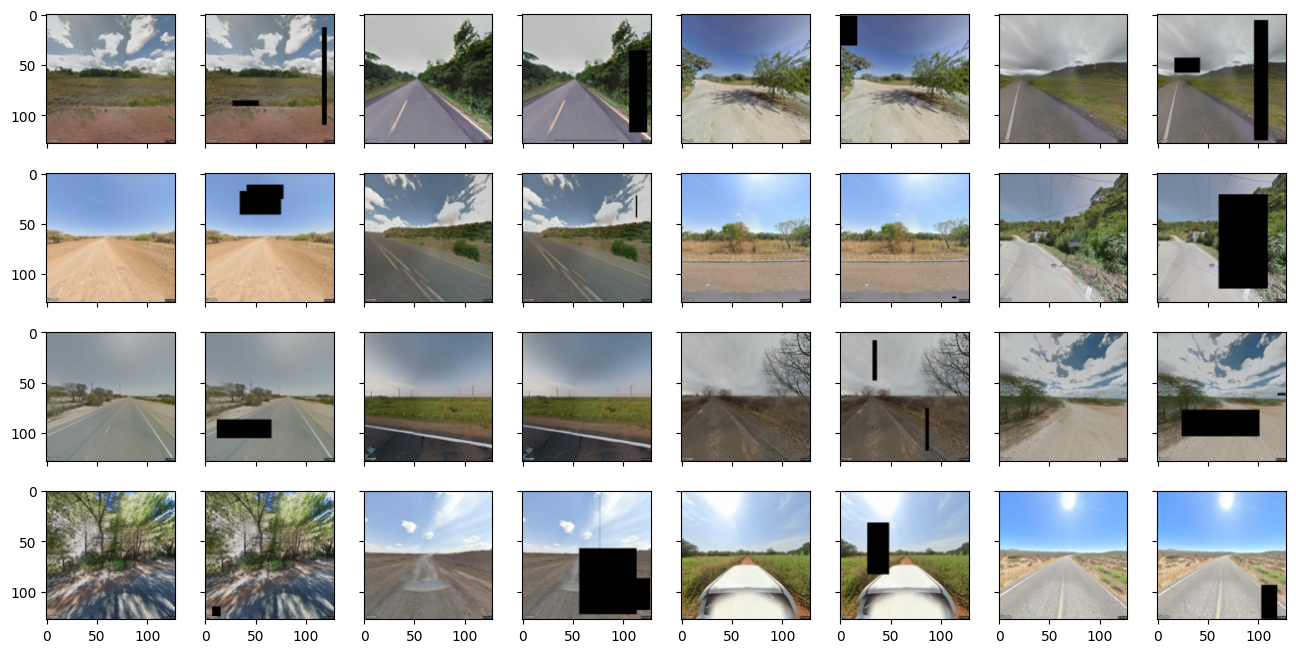

In [13]:
from torchvision import transforms
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, random_split
import numpy as np

if __name__ == "__main__":
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
    ])

    dataset_path = "paris"
    dataset_augmented = InpaintingDataset(root_dir=dataset_path, transform=transform)
    testing_dataset_augmented, test = random_split(dataset_augmented, [0.9, 0.1]) 
    train_loader = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)

    sample_masks, sample_labels = next(iter(train_loader))
    sample_images = [None] * (len(sample_masks) + len(sample_labels))
    sample_images[::2] = sample_labels
    sample_images[1::2] = sample_masks
    
    fig = plt.figure(figsize=(16., 8.))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.3)

    for ax, image in zip(grid, sample_images):
        image_rgb = image[[2, 1, 0], :, :]  
        ax.imshow(image_rgb.permute(1, 2, 0))

    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


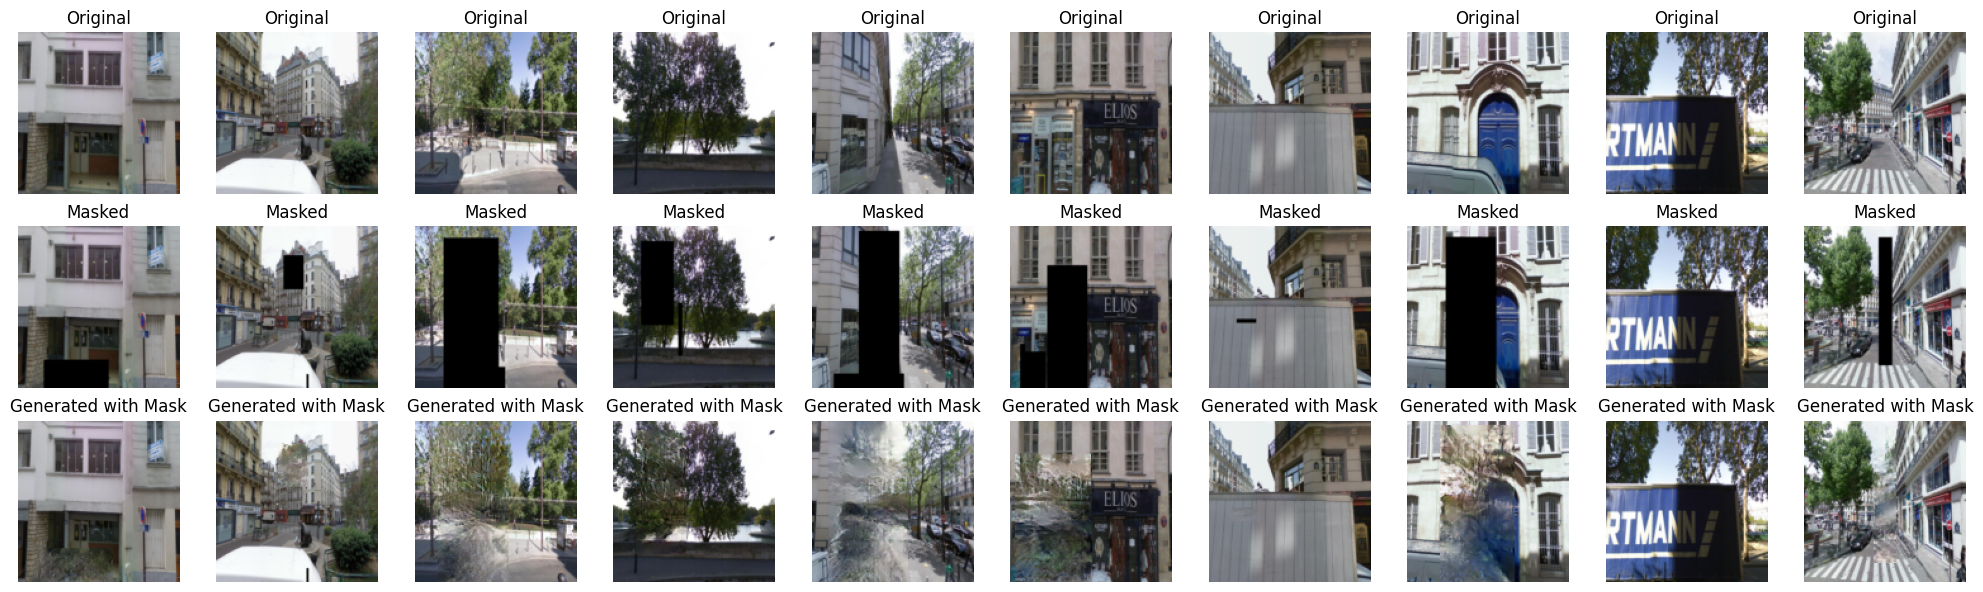

In [15]:

DisplayTest(testing_dataset_augmented)

Results satisfactory

Results were also satisfactory on the grass-dataset but those red flowers aint working at all

# **Saving the Generator**


So I can use it on the video code

In [ ]:
torch.save(generator.state_dict(), 'generator.pth')
